In [2]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

from operator import itemgetter

from pykalman import KalmanFilter

In [44]:
%matplotlib notebook

# Setup

#### Utility functions

In [4]:
def sample_data(getter, original_data, data_keys):
    sampled_data = {}
    for key in data_keys:
        sampled_data[key] = np.array(getter(original_data[key]))
    return sampled_data

In [ ]:
def sharpe_ratio(portfolio, values):
    """
    Empirical Sharpe ratio.
    """
    volumes = np.empty_like(portfolio)
    volumes[:] = portfolio
    volumes[np.where(volumes == 0)] = np.nan
    return np.nanmean(volumes*values)/np.sqrt(np.nanvar(volumes*values))

#### Load data & transform to data matrices with dims `[NUM_STOCKS, TIME]`

In [5]:
data = loadmat('portfolio.mat')
keys = ['hi', 'lo', 'open', 'close', 'vol', 'stocks']

all_data = {}
all_data['hi'] = np.nan_to_num(data['train_hi'].T)
all_data['lo'] = np.nan_to_num(data['train_lo'].T)
all_data['open'] = np.nan_to_num(data['train_op'].T)
all_data['close'] = np.nan_to_num(data['train_cl'].T)
all_data['vol'] = np.nan_to_num(data['train_vol'].T)
all_data['stocks'] = np.array([entry[0] for entry in data['train_stocks'][0]])
NUM_STOCKS = all_data['stocks'].shape[0]
TIME = all_data['open'].shape[1]

#### Split the dataset

In [6]:
NUM_TRAIN = 300
NUM_VALIDATION = 100
NUM_TEST = NUM_STOCKS - NUM_TRAIN - NUM_VALIDATION

In [7]:
permuted_stocks = np.random.permutation(NUM_STOCKS)
get_train = itemgetter(*permuted_stocks[:NUM_TRAIN])
get_validation = itemgetter(*permuted_stocks[NUM_TRAIN:NUM_TRAIN+NUM_VALIDATION])
get_test = itemgetter(*permuted_stocks[NUM_TRAIN+NUM_VALIDATION:NUM_STOCKS])

train_data = sample_data(get_train, all_data, keys)
validation_data = sample_data(get_validation, all_data, keys)
test_data = sample_data(get_test, all_data, keys)

# Framework

In [6]:
def simulate(init_portfolio, strategy, dataset):
    
    # initialize
    b_train = np.zeros([NUM_TRAIN, TIME+1])
    x_train = np.zeros([NUM_TRAIN, TIME])
    logS = np.zeros(TIME)
    
    x_train[:,0] = 1              # have no prior data
    b_train[:,0] = init_portfolio # have no knowledge for first portfolio
    logS[0] = 0                   # start at S=1
    
    # main loop
    for t in range(1,TIME):
        
        zero_locs = np.where(dataset[:,t-1] == 0)[0]
        nonzero_locs = np.where(dataset[:,t-1] != 0)[0]
        
        x_train[zero_locs,t] = 1
        x_train[nonzero_locs,t] = np.nan_to_num(dataset[nonzero_locs,t]/dataset[nonzero_locs,t-1])
        
        b_train[:,t] = strategy(b_train, x_train, t)
        
        logS[t] = logS[t-1] + np.log(np.dot(x_train[:,t], b_train[:,t]))
        
    return b_train, x_train, logS

In [8]:
def strategy(portfolio, dataset, timestep):
    pass

# Baselines

#### BAH

In [20]:
unif_init = 1./NUM_TRAIN * np.ones(NUM_TRAIN)

def BAH(portfolio, dataset, timestep):
    b = portfolio[:, timestep-1]
    x = dataset[:, timestep-1]
    return b*x/np.dot(b, x)

b, x, logS = simulate(unif_init, BAH, train_data['close'])
print np.exp(logS[-1])

1.42665913849


#### CRP

In [21]:
unif_init = 1./NUM_TRAIN * np.ones(NUM_TRAIN)

def CRP(portfolio, dataset, timestep):
    b = portfolio[:, timestep-1]
    x = dataset[:, timestep-1]
    return b

b, x, logS = simulate(unif_init, CRP, train_data['close'])

print np.exp(logS[-1]

1.66454376512


# Kalman Filter

In [42]:
def causal_kf(kf, dataset):
    
    means = [np.ones(NUM_TRAIN)]
    covariances = [np.eye(NUM_TRAIN)]
    
    for t in range(1,TIME):
        
        next_mean, next_covariance = kf.filter_update(means[-1], covariances[-1], dataset[:,t])
        means.append(next_mean)
        covariances.append(next_covariance)
        
    return means, covariances

kf = KalmanFilter(transition_matrices=np.eye(NUM_TRAIN),
                  observation_matrices=np.eye(NUM_TRAIN),
                  initial_state_mean=np.ones(NUM_TRAIN),
                  initial_state_covariance=np.eye(NUM_TRAIN),
                  observation_covariance=np.eye(NUM_TRAIN),
                  transition_covariance=0.1*np.eye(NUM_TRAIN))

means, variances = causal_kf(kf, train_data['close'])

data = train_data['close']
kalman = np.vstack(means).T

Look [here](https://pykalman.github.io/) for the Kalman filter API. Note that `kalman` has the same shape as `train_data['close']` 

<IPython.core.display.Javascript object>


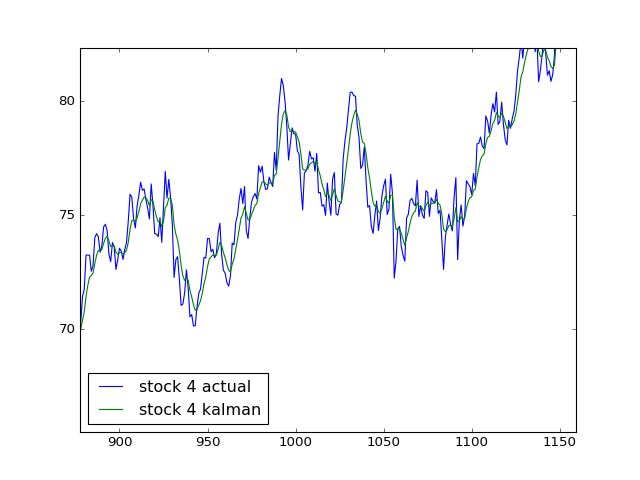

In [45]:
plt.figure()
plt.plot(data[4,:], label="stock 4 actual")
plt.plot(kalman[4,:], label="stock 4 kalman")
plt.legend(loc="best")
plt.show()